## Dyna-Q algorithm 

**Dyna-Q** integrates learning, planning, and acting into a single framework. It combines Q-learning with simulated updates from a learned model of the environment:


**Learning**: After taking an action \( a \) in state \( s \), observe reward \( r \) and next state \( s' \), then update the Q-value:
$$Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma \max_{a'} Q(s',a') - Q(s,a) \right]$$
  
**Modeling**: Store the transition $(s,a) \rightarrow (s',r)$ in a model.

**Planning**: Sample past transitions from the model and apply the same Q-learning update as if they came from the real environment.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 
import random
import time 

In [2]:
class CliffWalkingEnv:
    def __init__(self,ncol,nrow) -> None:
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0
        self.y = self.nrow - 1

    def step(self,action):
        change = [[0,-1],[0,1],[-1,0],[1,0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x >0:
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done 

    def reset(self):
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x 

In [3]:
class DynaQ:
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_planning, n_action = 4) -> None:
        self.Q_table = np.zeros([nrow*ncol, n_action])
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_planning = n_planning
        self.model = dict()

    def take_action(self,state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else: 
            action = np.argmax(self.Q_table[state])
        return action 
    
    def q_learning(self,s0,a0,r,s1):
        td_error = r + self.gamma * self.Q_table[s1].max() - self.Q_table[s0,a0]
        self.Q_table[s0,a0] += self.alpha * td_error

    def update(self,s0,a0,r,s1):
        self.q_learning(s0,a0,r,s1)
        self.model[(s0,a0)] = r,s1
        for _ in range(self.n_planning):
            (s,a),(r,s_) = random.choice(list(self.model.items()))
            self.q_learning(s,a,r,s_)

In [4]:
def DynaQ_CliffWalking(n_planning):
    ncol = 12
    nrow = 4
    env = CliffWalkingEnv(ncol, nrow)
    epsilon = 0.01
    alpha = 0.1
    gamma = 0.9
    agent = DynaQ(ncol, nrow, epsilon, alpha, gamma, n_planning)
    num_episode = 300

    return_list = []
    for i in range(10):
        with tqdm(total = int(num_episode/10), desc='Iteration %d' %i) as pbar:
            for i_epsidoe in range(int(num_episode/10)):
                episode_return = 0
                state = env.reset()
                done = False 
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done = env.step(action)
                    episode_return += reward
                    agent.update(state,action,reward,next_state)
                    state = next_state
                return_list.append(episode_return)
                if (i_epsidoe + 1) % 10 ==0:
                    pbar.set_postfix({
                        'episode' : '%d' % (num_episode /10 * i + i_epsidoe + 1),
                        'return' : '%.3f' %np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list

Q-planning step is 0


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 6557.36it/s, episode=300, return=-16.300]


Q-planning step is 2


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 3222.01it/s, episode=300, return=-13.000]


Q-planning step is 20


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 955.26it/s, episode=300, return=-22.100]


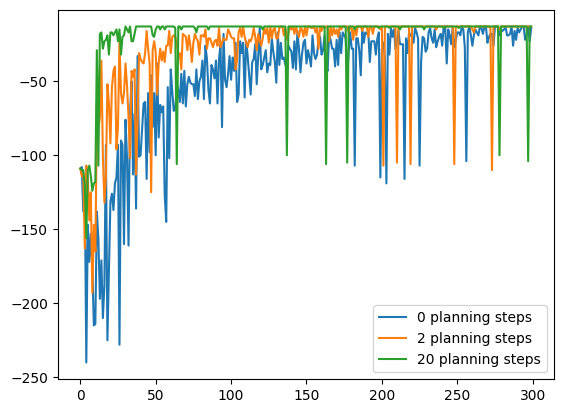

In [5]:
n_planning_list = [0,2,20]
for n_planning in n_planning_list:
    print('Q-planning step is %d' % n_planning)
    time.sleep(0.5)
    return_list = DynaQ_CliffWalking(n_planning)
    episodes_list = list(range(len(return_list)))
    plt.plot(episodes_list, return_list, label = str(n_planning) + ' planning steps')
    
plt.legend()
plt.show()
                        